# Class label distributions and dependencies 

- check class distributions
- infer dependencies between classes and consesus types
- correlations

## Import data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
metadata = pd.read_csv('../data/train.csv')

In [2]:
metadata.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## Expert consensus

<Axes: xlabel='expert_consensus'>

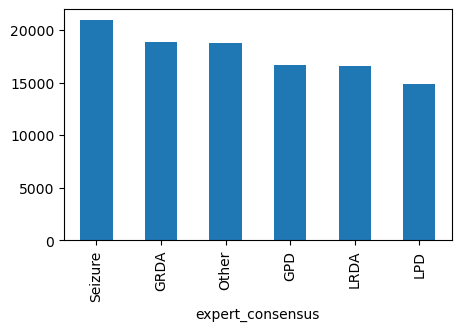

In [8]:
# make a barplot of the expert_consensus
plt.figure(figsize=(5, 3))
metadata['expert_consensus'].value_counts().plot(kind='bar')

In [9]:
metadata['total_votes'] = metadata['seizure_vote'] + metadata['lpd_vote'] + metadata['lrda_vote'] + metadata['gpd_vote'] + metadata['grda_vote'] + metadata['other_vote']

## Number of voters

<Axes: xlabel='total_votes'>

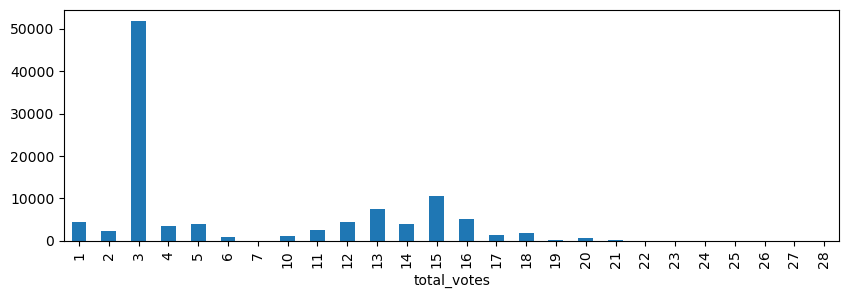

In [13]:
# display the distribution of the total_votes
plt.figure(figsize=(10, 3))
metadata['total_votes'].value_counts().sort_index().plot(kind='bar')

## Vote ratios value per class

In [14]:
metadata['seizure_votes_ratio'] = metadata['seizure_vote'] / metadata['total_votes']
metadata['lpd_votes_ratio'] = metadata['lpd_vote'] / metadata['total_votes']
metadata['lrda_votes_ratio'] = metadata['lrda_vote'] / metadata['total_votes']
metadata['gpd_votes_ratio'] = metadata['gpd_vote'] / metadata['total_votes']
metadata['grda_votes_ratio'] = metadata['grda_vote'] / metadata['total_votes']
metadata['other_votes_ratio'] = metadata['other_vote'] / metadata['total_votes']

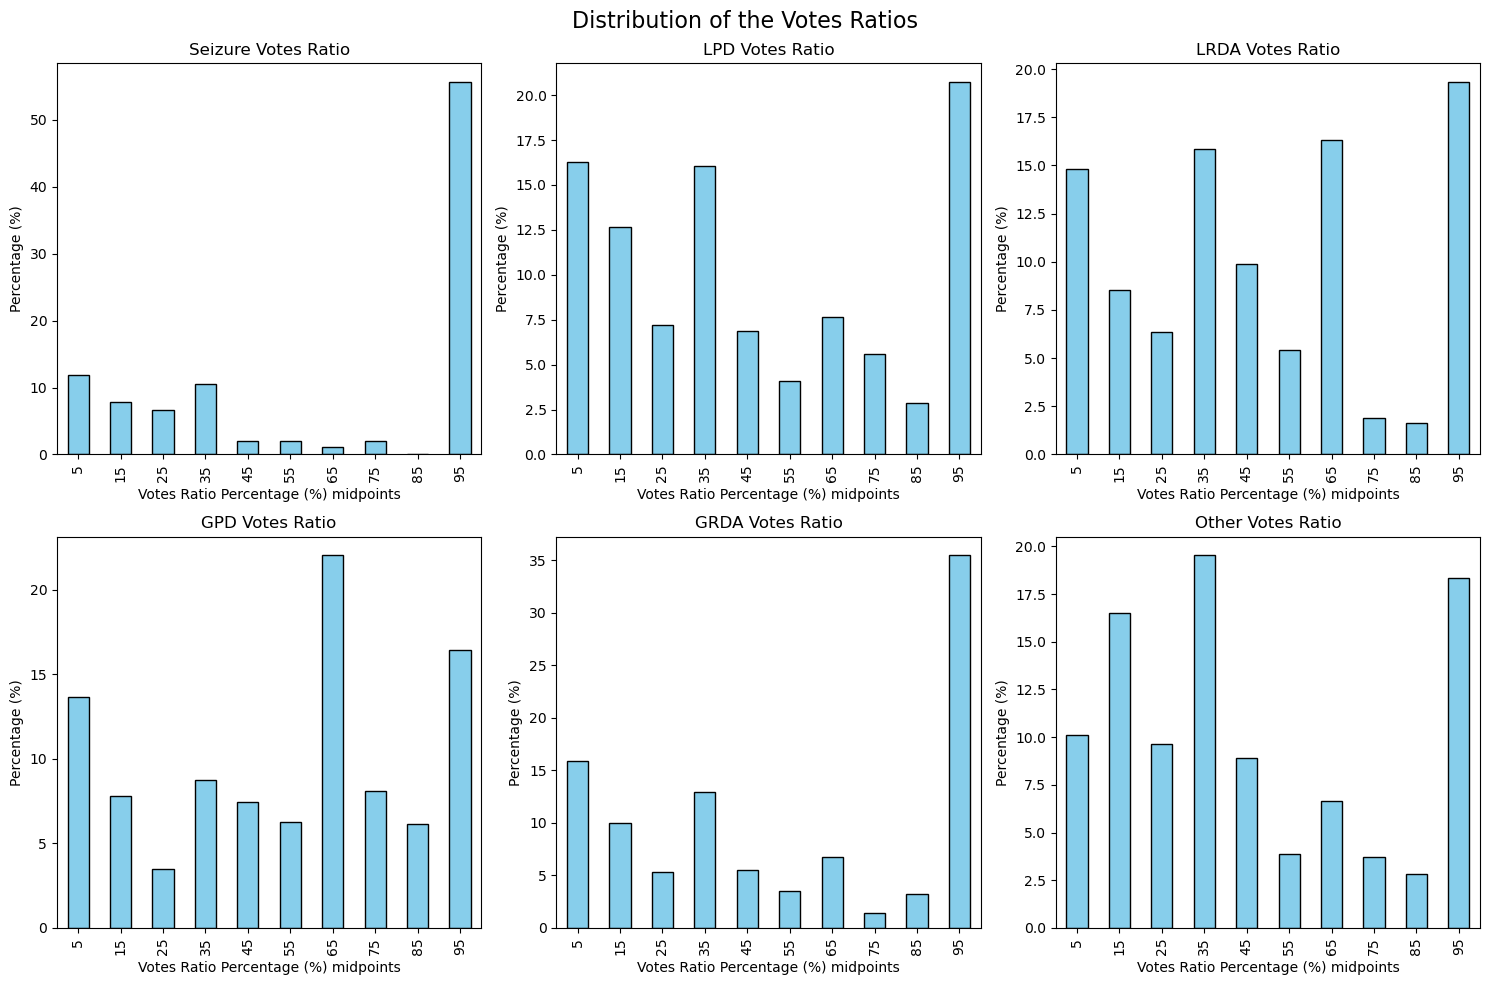

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the figure and the subplots
plt.figure(figsize=(15, 10))

# Define the number of bins
nbins = 10

# Plot the data
ratios = ['seizure_votes_ratio', 'lpd_votes_ratio', 'lrda_votes_ratio', 'gpd_votes_ratio', 'grda_votes_ratio', 'other_votes_ratio']
titles = ['Seizure Votes Ratio', 'LPD Votes Ratio', 'LRDA Votes Ratio', 'GPD Votes Ratio', 'GRDA Votes Ratio', 'Other Votes Ratio']

for i in range(6):
    plt.subplot(2, 3, i+1)
    # Calculate the bin edges
    bins = np.histogram_bin_edges(metadata[ratios[i]], bins=nbins)
    # Calculate the midpoints of the bins, as percentages as integers
    midpoints = ((bins[:-1] + np.diff(bins)/2) * 100).astype(int)
    # Create bins for the data
    data = pd.cut(metadata[ratios[i]], bins=bins, labels = midpoints)
    # Normalize the value counts and convert to percentage
    data = data.value_counts(normalize=True).sort_index() * 100
    data.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(titles[i])
    plt.xlabel('Votes Ratio Percentage (%) midpoints')
    plt.ylabel('Percentage (%)')

plt.suptitle('Distribution of the Votes Ratios', fontsize=16)

# Adjust the layout
plt.tight_layout()
plt.show()

## Consensus type

In [44]:
def label_consensus_type(row):
    vote_ratios = ['seizure_votes_ratio', 'lpd_votes_ratio', 'lrda_votes_ratio',
                    'gpd_votes_ratio', 'grda_votes_ratio', 'other_votes_ratio']
    
    for i in vote_ratios:
        if row[i] == 1:
            return 'idealized'
        if row[i] > 0.6:
            return 'majority'
        if 0.4 < row[i] < 0.6:
            for j in vote_ratios:
                if j != i and 0.4 < row[j] < 0.6:
                    return 'edge'
            return 'proto'
    else:
        return 'mixed'

metadata['consensus_type'] = metadata.apply(label_consensus_type, axis=1)

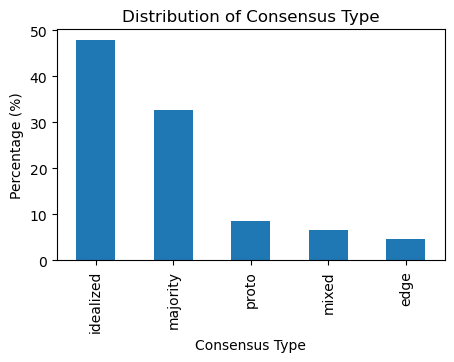

In [45]:
plt.figure(figsize=(5, 3))
(metadata['consensus_type'].value_counts(normalize=True) * 100).plot(kind='bar')
plt.xlabel('Consensus Type')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Consensus Type')
plt.show()



## Considerations

**Select weights for samples for training**
- idealized > majority > proto > edge
- relabel data as majority vote class
- exclude samples of label 'other'
- exclude mixed consensus type samples
- (how about doubling edge cases and including them with both once labels?)

**Target: Expert concensus vs class probabilites**
- this will help to get the expert consensus right
- for returning probability of sample belonging to each class proceed differently
- although relabelling and weighing should perform accurately even for that, since most samples are of idealized or majority consensus type


## Classes per consensus type

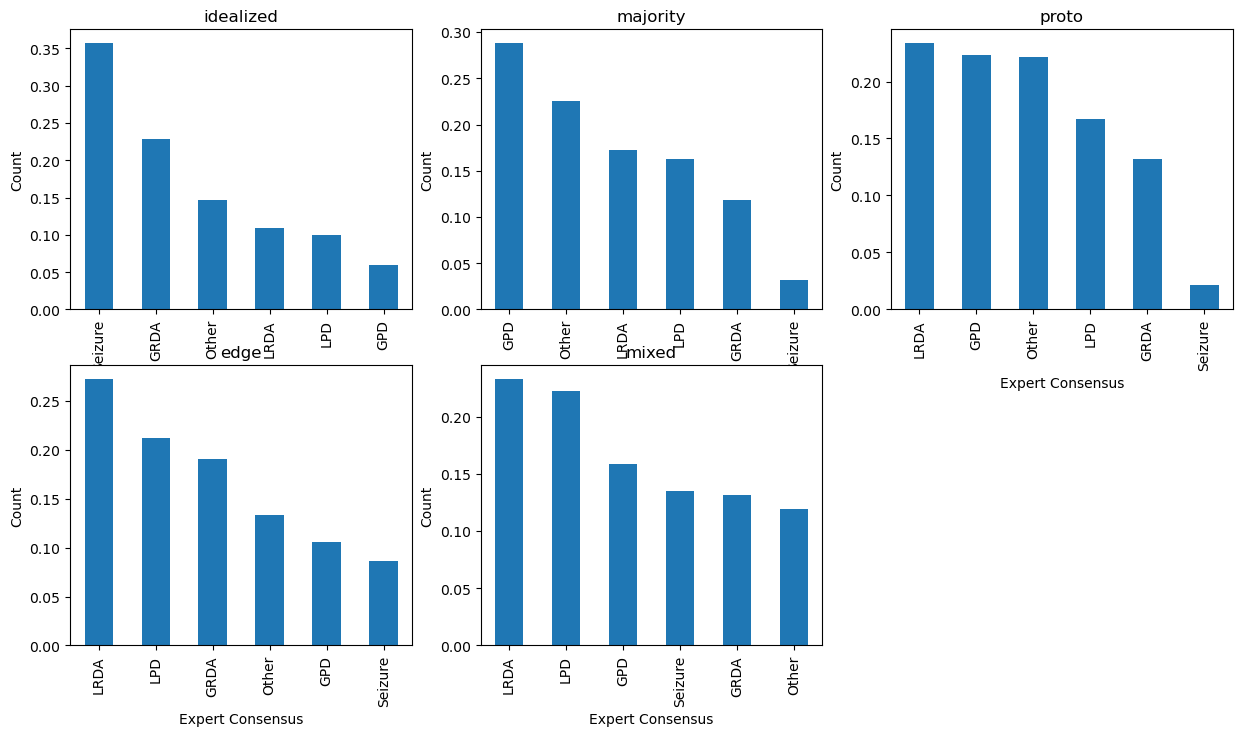

In [50]:
# plot the distribution of classes for each consensus type
plt.figure(figsize=(15, 8))
consensus_types = ['idealized', 'majority', 'proto', 'edge', 'mixed']
for i in consensus_types:
    plt.subplot(2, 3, consensus_types.index(i)+1)
    metadata[metadata['consensus_type'] == i]['expert_consensus'].value_counts(normalize=True).plot(kind='bar')
    plt.title(i)
    plt.xlabel('Expert Consensus')
    plt.ylabel('Count')


## Correlation of classes for edge cases

                     seizure_votes_ratio  lpd_votes_ratio  lrda_votes_ratio  \
seizure_votes_ratio             1.000000         0.028693         -0.251975   
lpd_votes_ratio                 0.028693         1.000000         -0.114612   
lrda_votes_ratio               -0.251975        -0.114612          1.000000   
gpd_votes_ratio                 0.142451        -0.040117         -0.383270   
grda_votes_ratio               -0.240572        -0.416539         -0.457472   
other_votes_ratio              -0.379340        -0.463465         -0.003320   

                     gpd_votes_ratio  grda_votes_ratio  other_votes_ratio  
seizure_votes_ratio         0.142451         -0.240572          -0.379340  
lpd_votes_ratio            -0.040117         -0.416539          -0.463465  
lrda_votes_ratio           -0.383270         -0.457472          -0.003320  
gpd_votes_ratio             1.000000         -0.125995          -0.418875  
grda_votes_ratio           -0.125995          1.000000           0

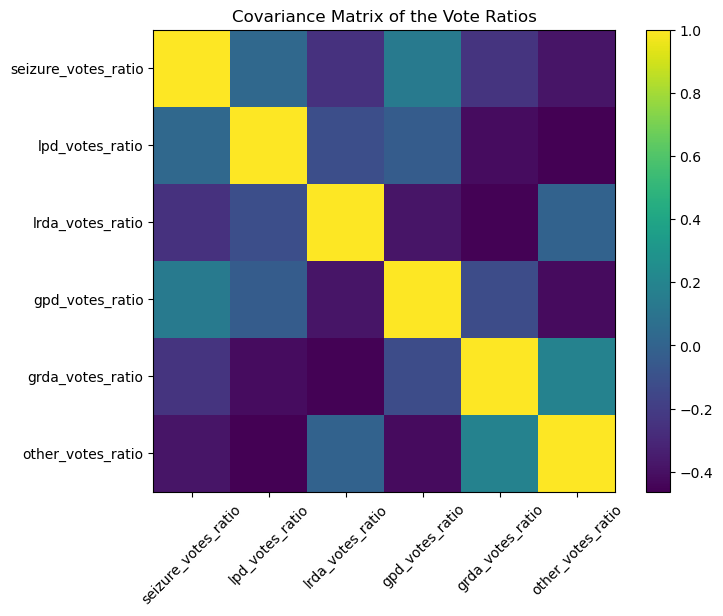

In [61]:
# Define the columns to use for the calculation
vote_ratios = ['seizure_votes_ratio', 'lpd_votes_ratio', 'lrda_votes_ratio', 'gpd_votes_ratio', 'grda_votes_ratio', 'other_votes_ratio']

# Filter the DataFrame for rows where 'consensus_type' is 'edge'
edge_metadata = metadata[metadata['consensus_type'] == 'edge']

# Calculate the covariance matrix for the specified columns
correlation_matrix = edge_metadata[vote_ratios].corr()

correlation_matrix

print(correlation_matrix)

# plot the covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(6), vote_ratios, rotation=45)
plt.yticks(range(6), vote_ratios)
plt.title('Covariance Matrix of the Vote Ratios')
plt.show()

## Correlation of classes overall

                     seizure_votes_ratio  lpd_votes_ratio  lrda_votes_ratio  \
seizure_votes_ratio             1.000000        -0.221757         -0.254536   
lpd_votes_ratio                -0.221757         1.000000         -0.120059   
lrda_votes_ratio               -0.254536        -0.120059          1.000000   
gpd_votes_ratio                -0.161980        -0.117910         -0.215871   
grda_votes_ratio               -0.286861        -0.232497         -0.164458   
other_votes_ratio              -0.330510        -0.156898         -0.112608   

                     gpd_votes_ratio  grda_votes_ratio  other_votes_ratio  
seizure_votes_ratio        -0.161980         -0.286861          -0.330510  
lpd_votes_ratio            -0.117910         -0.232497          -0.156898  
lrda_votes_ratio           -0.215871         -0.164458          -0.112608  
gpd_votes_ratio             1.000000         -0.197931          -0.174864  
grda_votes_ratio           -0.197931          1.000000          -0

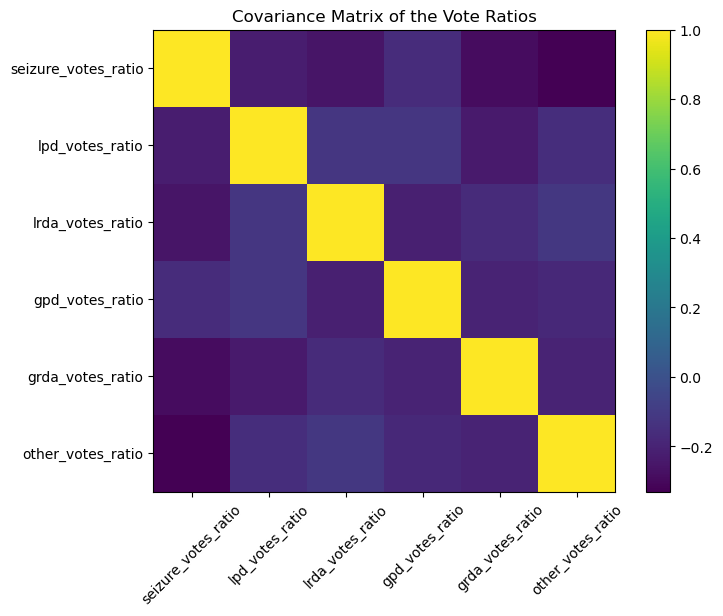

In [62]:
# Define the columns to use for the calculation
vote_ratios = ['seizure_votes_ratio', 'lpd_votes_ratio', 'lrda_votes_ratio', 'gpd_votes_ratio', 'grda_votes_ratio', 'other_votes_ratio']

# Calculate the covariance matrix for the specified columns
correlation_matrix = metadata[vote_ratios].corr()

print(correlation_matrix)

# plot the covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(6), vote_ratios, rotation=45)
plt.yticks(range(6), vote_ratios)
plt.title('Covariance Matrix of the Vote Ratios')
plt.show()